In [1]:
import collections
import functools
import IPython
import itertools
import numpy as np
import os
import pandas as pd
import pathlib
import pypandoc
import requests
import string
import sys
import time
import typing
import us
import zipfile

from datetime import datetime
from tqdm.notebook import tqdm_notebook

module_path = os.path.abspath(os.path.join("../.."))
if module_path not in sys.path:
    sys.path.append(module_path)

from data_pipeline.utils import remove_all_from_dir, get_excel_column_name
from data_pipeline.etl.base import ExtractTransformLoad
from data_pipeline.etl.sources.census.etl_utils import get_state_information
from data_pipeline.etl.sources.ejscreen_areas_of_concern.etl import (
    EJSCREENAreasOfConcernETL,
)


from data_pipeline.score import field_names

%load_ext lab_black
# Turn on TQDM for pandas so that we can have progress bars when running `apply`.
tqdm_notebook.pandas()

In [2]:
# Suppress scientific notation in pandas (this shows up for census tract IDs)
pd.options.display.float_format = "{:.2f}".format

# Set some global parameters
DATA_DIR = pathlib.Path.cwd().parent / "data"
TEMP_DATA_DIR = DATA_DIR / "tmp"

time_str = time.strftime("%Y%m%d-%H%M%S")

COMPARISON_OUTPUTS_DIR = DATA_DIR / "comparison_outputs" / time_str

# Make the dirs if they don't exist
TEMP_DATA_DIR.mkdir(parents=True, exist_ok=True)
COMPARISON_OUTPUTS_DIR.mkdir(parents=True, exist_ok=True)

CEJST_PRIORITY_COMMUNITY_THRESHOLD = 0.75

# Name fields using variables. (This makes it easy to reference the same fields frequently without using strings
# and introducing the risk of misspelling the field name.)
GEOID_STATE_FIELD_NAME = "GEOID10_STATE"
COUNTRY_FIELD_NAME = "Country"

# Define some suffixes
POPULATION_SUFFIX = " (priority population)"

In [3]:
# Load CEJST score data
cejst_data_path = DATA_DIR / "score" / "csv" / "full" / "usa.csv"
cejst_df = pd.read_csv(
    cejst_data_path,
    dtype={ExtractTransformLoad.GEOID_TRACT_FIELD_NAME: "string"},
)

# Create the state ID by taking the first two digits of the FIPS CODE of the tract.
# For more information, see https://www.census.gov/programs-surveys/geography/guidance/geo-identifiers.html.
cejst_df.loc[:, GEOID_STATE_FIELD_NAME] = (
    cejst_df.loc[:, ExtractTransformLoad.GEOID_TRACT_FIELD_NAME].astype(str).str[0:2]
)

cejst_df.head()

/usr/local/Cellar/jupyterlab/3.2.8/libexec/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3251: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,GEOID10_TRACT,Persistent Poverty Census Tract,Housing burden (percent),Total population,Median household income (% of state median household income),Current asthma among adults aged greater than or equal to 18 years,Coronary heart disease among adults aged greater than or equal to 18 years,Cancer (excluding skin cancer) among adults aged greater than or equal to 18 years,Current lack of health insurance among adults aged 18-64 years,Diagnosed diabetes among adults aged greater than or equal to 18 years,...,Score D (top 25th percentile),Score D (top 30th percentile),Score D (top 35th percentile),Score D (top 40th percentile),Score E (percentile),Score E (top 25th percentile),Score E (top 30th percentile),Score E (top 35th percentile),Score E (top 40th percentile),GEOID10_STATE
0,01073001100,True,0.28,4897.00,0.73,11.20,7.20,6.70,16.60,19.30,...,False,False,False,False,0.33,False,False,False,False,01
1,01073001400,True,0.18,1906.00,0.71,11.10,9.10,7.30,21.40,22.40,...,False,False,True,True,0.73,False,True,True,True,01
2,01073002000,False,0.44,4215.00,0.54,13.50,9.50,6.10,25.40,22.80,...,True,True,True,True,0.93,True,True,True,True,01
3,01073003802,False,0.41,5149.00,0.77,12.00,6.60,5.60,20.90,18.60,...,True,True,True,True,0.76,True,True,True,True,01
4,01073004000,True,0.47,2621.00,0.37,13.10,10.00,6.30,24.50,25.00,...,True,True,True,True,0.95,True,True,True,True,01


In [4]:
# Load EJSCREEN Areas of Concern data.

# Load EJ Screen Areas of Concern
# Before attempting, check whether or not the EJSCREEN AoC data is available locally.
# Note: this data is provided privately and is not currently publicly available.
# To enable the ETL code for EJSCREEN AoCs to run appropriately whether or not the person
# running it has access to that data, `ejscreen_areas_of_concern_data_exists` checks whether the source file exists.
# If it does exist, code can and should include this data. If it does not exist, code should
# not reference this data.
ejscreen_areas_of_concern_df: pd.DataFrame = None

if EJSCREENAreasOfConcernETL.ejscreen_areas_of_concern_data_exists():
    print("Loading EJSCREEN Areas of Concern data for score pipeline.")
    ejscreen_areas_of_concern_csv = (
        DATA_DIR / "dataset" / "ejscreen_areas_of_concern" / "usa.csv"
    )
    ejscreen_areas_of_concern_df = pd.read_csv(
        ejscreen_areas_of_concern_csv,
        dtype={ExtractTransformLoad.GEOID_FIELD_NAME: "string"},
        low_memory=False,
    )
else:
    print(
        "EJSCREEN areas of concern data does not exist locally. Not attempting to load data into comparison tool."
    )

EJSCREEN areas of concern data does not exist locally. Not attempting to load data into comparison tool.


In [5]:
# Merge EJSCREEN AoCs into CEJST data.
# Before attempting, check whether or not the EJSCREEN AoC data is available locally.
if EJSCREENAreasOfConcernETL.ejscreen_areas_of_concern_data_exists():
    # If available, merge EJSCREEN AoC data into CBG dfs.
    # TODO: When we get AoC data at the tract level, fix this.
    # Right now commenting this out to avoid merging CBG-level areas of concern on a tract-level CEJST definition.
    # cejst_df = cejst_df.merge(
    #     ejscreen_areas_of_concern_df, on=GEOID_FIELD_NAME, how="outer"
    # )
    pass
else:
    pass

cejst_df.head()

,GEOID10_TRACT,Persistent Poverty Census Tract,Housing burden (percent),Total population,Median household income (% of state median household income),Current asthma among adults aged greater than or equal to 18 years,Coronary heart disease among adults aged greater than or equal to 18 years,Cancer (excluding skin cancer) among adults aged greater than or equal to 18 years,Current lack of health insurance among adults aged 18-64 years,Diagnosed diabetes among adults aged greater than or equal to 18 years,...,Score D (top 25th percentile),Score D (top 30th percentile),Score D (top 35th percentile),Score D (top 40th percentile),Score E (percentile),Score E (top 25th percentile),Score E (top 30th percentile),Score E (top 35th percentile),Score E (top 40th percentile),GEOID10_STATE
0,01073001100,True,0.28,4897.00,0.73,11.20,7.20,6.70,16.60,19.30,...,False,False,False,False,0.33,False,False,False,False,01
1,01073001400,True,0.18,1906.00,0.71,11.10,9.10,7.30,21.40,22.40,...,False,False,True,True,0.73,False,True,True,True,01
2,01073002000,False,0.44,4215.00,0.54,13.50,9.50,6.10,25.40,22.80,...,True,True,True,True,0.93,True,True,True,True,01
3,01073003802,False,0.41,5149.00,0.77,12.00,6.60,5.60,20.90,18.60,...,True,True,True,True,0.76,True,True,True,True,01
4,01073004000,True,0.47,2621.00,0.37,13.10,10.00,6.30,24.50,25.00,...,True,True,True,True,0.95,True,True,True,True,01



~~~~Analysis for field `Percent enrollment in college or graduate school`~~~~
count   73298.00
mean        0.08
std         0.09
min         0.00
25%         0.04
50%         0.06
75%         0.09
max         1.00
Name: Percent enrollment in college or graduate school, dtype: float64

There are 1.16% of values missing.

Quantile at 0.9 is 0.12186292304275304
AxesSubplot(0.125,0.125;0.775x0.755)

~~~~Analysis for field `Percent individuals age 25 or over with less than high school degree`~~~~
count   73280.00
mean        0.13
std         0.10
min         0.00
25%         0.05
50%         0.10
75%         0.17
max         1.00
Name: Percent individuals age 25 or over with less than high school degree, dtype: float64

There are 1.19% of values missing.

Quantile at 0.9 is 0.2693215167829206
AxesSubplot(0.125,0.125;0.775x0.755)

~~~~Analysis for field `Median household income as a percent of area median income`~~~~
count   69113.00
mean        1.01
std         0.43
min         0.04
25%   

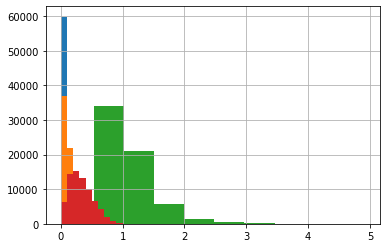

In [6]:
# Analyze one field at a time (useful for setting thresholds)

quantile = 0.90

for field in [
    field_names.COLLEGE_ATTENDANCE_FIELD,
    field_names.HIGH_SCHOOL_ED_FIELD,
    field_names.MEDIAN_INCOME_AS_PERCENT_OF_AMI_FIELD,
    field_names.POVERTY_LESS_THAN_200_FPL_FIELD,
]:
    print(f"\n~~~~Analysis for field `{field}`~~~~")
    print(cejst_df[field].describe())
    print(
        f"\nThere are {cejst_df[field].isnull().sum() * 100 / len(cejst_df):.2f}% of values missing."
    )
    print(
        f"\nQuantile at {quantile} is {np.nanquantile(a=cejst_df[field], q=quantile)}"
    )
    print(cejst_df[field].hist())

In [7]:
# Load CalEnviroScreen 4.0
CALENVIROSCREEN_SCORE_FIELD = "calenviroscreen_score"
CALENVIROSCREEN_PERCENTILE_FIELD = "calenviroscreen_percentile"
CALENVIROSCREEN_PRIORITY_COMMUNITY_FIELD = "calenviroscreen_priority_community"

calenviroscreen_data_path = DATA_DIR / "dataset" / "calenviroscreen4" / "data06.csv"
calenviroscreen_df = pd.read_csv(
    calenviroscreen_data_path,
    dtype={ExtractTransformLoad.GEOID_TRACT_FIELD_NAME: "string"},
)

# Convert priority community field to a bool.
calenviroscreen_df[CALENVIROSCREEN_PRIORITY_COMMUNITY_FIELD] = calenviroscreen_df[
    CALENVIROSCREEN_PRIORITY_COMMUNITY_FIELD
].astype(bool)

calenviroscreen_df.head()

,GEOID10_TRACT,Total Population,California County,ZIP,Nearby City \n(to help approximate location only),Longitude,Latitude,calenviroscreen_score,calenviroscreen_percentile,DRAFT CES 4.0\nPercentile Range,...,Poverty,Poverty Pctl,Unemployment,Unemployment Pctl,Housing Burden,Housing Burden Pctl,Pop. Char.,Pop. Char. Score,Pop. Char. Pctl,calenviroscreen_priority_community
0,06019001100,2760,Fresno,93706,Fresno,-119.78,36.71,94.61,100.00,95-100% (highest scores),...,76.60,98.43,16.20,97.15,30.70,90.61,93.73,9.72,99.87,True
1,06077000700,4177,San Joaquin,95206,Stockton,-121.29,37.94,90.83,99.99,95-100% (highest scores),...,70.60,96.43,18.50,98.45,35.20,95.61,93.40,9.68,99.84,True
2,06077000100,4055,San Joaquin,95202,Stockton,-121.29,37.95,85.75,99.97,95-100% (highest scores),...,81.80,99.50,17.90,98.17,36.40,96.51,95.71,9.92,99.97,True
3,06071001600,5527,San Bernardino,91761,Ontario,-117.62,34.06,83.56,99.96,95-100% (highest scores),...,67.10,94.82,6.70,57.20,32.10,92.65,80.59,8.36,93.06,True
4,06037204920,2639,Los Angeles,90023,Los Angeles,-118.20,34.02,82.90,99.95,95-100% (highest scores),...,64.90,93.51,5.60,43.81,25.00,77.95,83.95,8.70,95.78,True


In [8]:
# Mapping for EJ
mapping_for_ej_path = DATA_DIR / "dataset" / "mapping_for_ej" / "co_va.csv"

mapping_for_ej_df = pd.read_csv(
    mapping_for_ej_path,
    dtype={
        ExtractTransformLoad.GEOID_TRACT_FIELD_NAME: "string",
        field_names.MAPPING_FOR_EJ_PRIORITY_COMMUNITY_FIELD: "bool",
    },
)

mapping_for_ej_df.head()

,GEOID10_TRACT,Mapping for Environmental Justice Final Percentile,Mapping for Environmental Justice Final Score,Mapping for Environmental Justice Priority Community
0,51097950400,48.12,22.70,False
1,51550020001,46.20,22.17,False
2,51041100206,72.51,32.90,False
3,51059481000,74.87,34.25,False
4,51059451400,96.41,57.83,True


In [9]:
# Load persistent poverty data
persistent_poverty_path = DATA_DIR / "dataset" / "persistent_poverty" / "usa.csv"
persistent_poverty_df = pd.read_csv(
    persistent_poverty_path,
    dtype={ExtractTransformLoad.GEOID_TRACT_FIELD_NAME: "string"},
)

# Since "Persistent Poverty Census Tract" is labeled in both the score file (at the CBG level) and this tract file,
# rename this field so it's easy to access the tract-level scores directly.

PERSISTENT_POVERTY_TRACT_LEVEL_FIELD = "Persistent Poverty, Tract Level"
PERSISTENT_POVERTY_CBG_LEVEL_FIELD = "Persistent Poverty Census Tract"

persistent_poverty_df.rename(
    columns={PERSISTENT_POVERTY_CBG_LEVEL_FIELD: PERSISTENT_POVERTY_TRACT_LEVEL_FIELD},
    inplace=True,
    errors="raise",
)

persistent_poverty_df

,GEOID10_TRACT,Individuals in Poverty (percent) (1990),Individuals in Poverty (percent) (2000),Individuals in Poverty (percent) (2010),"Persistent Poverty, Tract Level"
0,01001020100,0.10,0.13,0.09,False
1,01001020200,0.20,0.23,0.11,False
2,01001020300,0.11,0.08,0.12,False
3,01001020400,0.07,0.05,0.03,False
4,01001020500,0.06,0.04,0.08,False
...,...,...,...,...,...
73071,55079990000,NaN,NaN,NaN,False
73072,55083990000,NaN,NaN,NaN,False
73073,55089990000,NaN,NaN,NaN,False
73074,55101990000,NaN,NaN,NaN,False


In [10]:
# Load mapping inequality data
HOLC_FACTORS = [
    field_names.HOLC_GRADE_D_TRACT_20_PERCENT_FIELD,
    field_names.HOLC_GRADE_D_TRACT_50_PERCENT_FIELD,
    field_names.HOLC_GRADE_D_TRACT_75_PERCENT_FIELD,
]
mapping_inequality_path = DATA_DIR / "dataset" / "mapping_inequality" / "usa.csv"
mapping_inequality_df = pd.read_csv(
    mapping_inequality_path,
    dtype={ExtractTransformLoad.GEOID_TRACT_FIELD_NAME: "string"},
)

mapping_inequality_df

,GEOID10_TRACT,Percent of tract that is HOLC Grade D,Tract is >20% HOLC Grade D,Tract is >50% HOLC Grade D,Tract is >75% HOLC Grade D
0,01073000100,0.42,True,False,False
1,01073000300,0.93,True,True,True
2,01073000400,0.36,True,False,False
3,01073000500,0.65,True,True,False
4,01073000700,0.41,True,False,False
...,...,...,...,...,...
7273,55139001100,0.29,True,False,False
7274,55139001200,0.42,True,False,False
7275,55139001300,0.16,False,False,False
7276,55139001400,0.04,False,False,False


In [11]:
cdc_svi_index_path = DATA_DIR / "dataset" / "cdc_svi_index" / "usa.csv"
cdc_svi_index_df = pd.read_csv(
    cdc_svi_index_path,
    dtype={ExtractTransformLoad.GEOID_TRACT_FIELD_NAME: "string"},
)
cdc_svi_index_df.head()

,GEOID10_TRACT,SVI - Socioeconomic Index (percentile),SVI - Household Composition Index (percentile),SVI- Minority Status/Language Index (percentile),SVI- Housing Type/Transportation Index (percentile),Overall rank for Social Vulnerability Indices (percentile),At or above 90 for overall percentile ranking according to Social Vulnerability Indices
0,01015981901,NaN,NaN,NaN,NaN,NaN,False
1,01015981902,NaN,NaN,NaN,NaN,NaN,False
2,01015981903,NaN,NaN,NaN,NaN,NaN,False
3,01097003605,NaN,0.00,0.27,NaN,NaN,False
4,01097990000,NaN,NaN,NaN,NaN,NaN,False


In [12]:
# Load Maryland EJScreen
maryland_ejscreen_data_path = (
    DATA_DIR / "dataset" / "maryland_ejscreen" / "maryland.csv"
)
maryland_ejscreen_df = pd.read_csv(
    maryland_ejscreen_data_path,
    dtype={ExtractTransformLoad.GEOID_TRACT_FIELD_NAME: "string"},
)

maryland_ejscreen_df.tail()

,GEOID10_TRACT,Maryland Environmental Justice Score,Maryland EJSCREEN Priority Community
1379,24027601107,0.66,True
1380,24027602201,0.30,False
1381,24027605504,0.28,False
1382,24027606904,0.43,False
1383,24027606906,0.54,False


In [13]:
# Load alternative energy-related definition
energy_definition_alternative_draft_path = (
    DATA_DIR / "dataset" / "energy_definition_alternative_draft" / "usa.csv"
)
energy_definition_alternative_draft_df = pd.read_csv(
    energy_definition_alternative_draft_path,
    dtype={ExtractTransformLoad.GEOID_TRACT_FIELD_NAME: "string"},
)

energy_definition_alternative_draft_df

,GEOID10_TRACT,Energy-related alternative definition of communities,Coal employment,Outage Events,Homelessness,Disabled population,Outage Duration,Job Access,Fossil energy employment,Food Desert,Incomplete Plumbing,Non-grid-connected heating fuel,Parks,Greater than 30 min commute,Internet Access,Mobile Home,Single Parent,Transportation Costs
0,35029000500,True,0.00,0.00,0.01,0.22,0.00,-1.40,0.02,1.00,0.00,0.36,0.00,0.25,30.70,0.53,0.75,45.00
1,48311950100,False,0.00,0.00,0.01,0.17,0.00,-1.30,0.01,1.00,0.02,0.04,-1.00,0.31,21.90,0.33,0.18,34.00
2,48131950500,True,0.00,0.00,0.01,0.29,0.00,-1.50,0.01,1.00,0.02,0.15,0.00,0.54,33.90,0.15,0.45,40.00
3,48247950200,False,0.00,1.00,0.01,0.22,1140.00,-3.00,0.01,0.00,0.00,0.01,0.00,0.33,29.40,0.11,0.53,37.00
4,48247950400,True,0.00,1.00,0.01,0.22,1140.00,-2.70,0.01,1.00,0.01,0.03,0.00,0.36,53.10,0.11,0.78,41.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73051,55111000500,False,NaN,NaN,NaN,0.12,NaN,NaN,NaN,NaN,0.00,0.30,NaN,NaN,NaN,0.10,0.32,NaN
73052,55111000700,False,NaN,NaN,NaN,0.11,NaN,NaN,NaN,NaN,0.01,0.07,NaN,NaN,NaN,0.00,0.25,NaN
73053,55111000800,False,NaN,NaN,NaN,0.14,NaN,NaN,NaN,NaN,0.01,0.46,NaN,NaN,NaN,0.05,0.22,NaN
73054,55111000900,False,NaN,NaN,NaN,0.11,NaN,NaN,NaN,NaN,0.03,0.78,NaN,NaN,NaN,0.02,0.25,NaN


In [14]:
# Load Michigan EJSCREEN
michigan_ejscreen_data_path = (
    DATA_DIR / "dataset" / "michigan_ejscreen" / "michigan_ejscreen.csv"
)
michigan_ejscreen_df = pd.read_csv(
    michigan_ejscreen_data_path,
    dtype={ExtractTransformLoad.GEOID_TRACT_FIELD_NAME: "string"},
)

michigan_ejscreen_df.head()

,GEOID10_TRACT,Michigan EJSCREEN Score Field,Michigan EJSCREEN Percentile Field,Michigan EJSCREEN Priority Community
0,26081003900,93.99,1.00,True
1,26077000202,91.95,1.00,True
2,26077000300,90.17,1.00,True
3,26081003800,89.50,1.00,True
4,26081004000,87.74,1.00,True


In [15]:
# Load EPA RSEI EJSCREEN
epa_rsei_data_path = DATA_DIR / "dataset" / "epa_rsei" / "usa.csv"
epa_rsei_df = pd.read_csv(
    epa_rsei_data_path,
    dtype={ExtractTransformLoad.GEOID_TRACT_FIELD_NAME: "string"},
)

epa_rsei_df.head()

,GEOID10_TRACT,Number of facilities affecting the tract,Number of releases affecting the tract,Number of chemicals affecting the tract,Average toxicity-weighted concentration of the cells in the tract,RSEI Risk Score,RSEI Risk Score (Cancer toxicity weights),RSEI Risk Score (Noncancer toxicity weights),Sum of the population of the cells in the tract,At or above 75 for overall percentile for the RSEI score,RSEI Risk Score (percentile)
0,36047023200,193,904,96,485.18,759.71,610.32,154.85,6199.22,False,0.53
1,36029007202,84,376,81,227.37,79.50,63.05,14.81,1601.87,False,0.21
2,42003429201,144,1624,251,2705.16,2553.95,2447.72,113.75,4527.60,False,0.74
3,17201004100,80,365,57,3626.62,3984.97,3969.13,27.06,5766.72,True,0.82
4,47065011203,79,358,79,1133.40,1885.51,1410.31,447.77,7820.66,False,0.69


In [16]:
# Join all dataframes that use tracts
census_tract_dfs = [
    cejst_df,
    calenviroscreen_df,
    persistent_poverty_df,
    mapping_inequality_df,
    epa_rsei_df,
    maryland_ejscreen_df,
    energy_definition_alternative_draft_df,
    michigan_ejscreen_df,
    cdc_svi_index_df,
    mapping_for_ej_df,
]

merged_df = functools.reduce(
    lambda left, right: pd.merge(
        left=left,
        right=right,
        on=ExtractTransformLoad.GEOID_TRACT_FIELD_NAME,
        how="outer",
    ),
    census_tract_dfs,
)

tract_values = merged_df[ExtractTransformLoad.GEOID_TRACT_FIELD_NAME].str.len().unique()
if any(tract_values != [11]):
    print(tract_values)
    raise ValueError("Some of the census tract data has the wrong length.")

if len(merged_df) > ExtractTransformLoad.EXPECTED_MAX_CENSUS_TRACTS:
    raise ValueError(f"Too many rows in the join: {len(merged_df)}.")

merged_df.head()

,GEOID10_TRACT,Persistent Poverty Census Tract,Housing burden (percent),Total population,Median household income (% of state median household income),Current asthma among adults aged greater than or equal to 18 years,Coronary heart disease among adults aged greater than or equal to 18 years,Cancer (excluding skin cancer) among adults aged greater than or equal to 18 years,Current lack of health insurance among adults aged 18-64 years,Diagnosed diabetes among adults aged greater than or equal to 18 years,...,Michigan EJSCREEN Priority Community,SVI - Socioeconomic Index (percentile),SVI - Household Composition Index (percentile),SVI- Minority Status/Language Index (percentile),SVI- Housing Type/Transportation Index (percentile),Overall rank for Social Vulnerability Indices (percentile),At or above 90 for overall percentile ranking according to Social Vulnerability Indices,Mapping for Environmental Justice Final Percentile,Mapping for Environmental Justice Final Score,Mapping for Environmental Justice Priority Community
0,01073001100,True,0.28,4897.00,0.73,11.20,7.20,6.70,16.60,19.30,...,NaN,0.62,0.98,0.50,0.40,0.69,False,NaN,NaN,NaN
1,01073001400,True,0.18,1906.00,0.71,11.10,9.10,7.30,21.40,22.40,...,NaN,0.80,0.57,0.85,0.23,0.68,False,NaN,NaN,NaN
2,01073002000,False,0.44,4215.00,0.54,13.50,9.50,6.10,25.40,22.80,...,NaN,0.95,0.82,0.73,0.96,0.97,True,NaN,NaN,NaN
3,01073003802,False,0.41,5149.00,0.77,12.00,6.60,5.60,20.90,18.60,...,NaN,0.85,0.81,0.50,0.49,0.76,False,NaN,NaN,NaN
4,01073004000,True,0.47,2621.00,0.37,13.10,10.00,6.30,24.50,25.00,...,NaN,0.96,0.71,0.86,0.85,0.95,True,NaN,NaN,NaN


In [17]:
# Special handling for HOLC.
# Fill in the null HOLC values as `False`. Otherwise the comparison tool will not run comparisons in states
# without HOLC scores, and for HOLC, we'd like to see it across the whole US.
for holc_factor in HOLC_FACTORS:
    merged_df[holc_factor] = merged_df[holc_factor].fillna(False)

merged_df[HOLC_FACTORS].head()

,Tract is >20% HOLC Grade D,Tract is >50% HOLC Grade D,Tract is >75% HOLC Grade D
0,True,False,False
1,True,True,True
2,False,False,False
3,True,False,False
4,True,False,False


In [18]:
# Define a namedtuple for indices.
Index = collections.namedtuple(
    typename="Index",
    field_names=[
        "method_name",
        "priority_communities_field",
    ],
)

# Define the indices used for CEJST scoring (`census_block_group_indices`) as well as comparison
# (`census_tract_indices`).
definition_l_factors = [
    field_names.L_CLIMATE,
    field_names.L_ENERGY,
    field_names.L_TRANSPORTATION,
    field_names.L_HOUSING,
    field_names.L_POLLUTION,
    field_names.L_WATER,
    field_names.L_HEALTH,
    field_names.L_WORKFORCE,
    # Also include a combined factor for all the non-workforce elements.
    field_names.L_NON_WORKFORCE,
]

definition_m_factors = [
    field_names.M_CLIMATE,
    field_names.M_ENERGY,
    field_names.M_TRANSPORTATION,
    field_names.M_HOUSING,
    field_names.M_POLLUTION,
    field_names.M_WATER,
    field_names.M_HEALTH,
    field_names.M_WORKFORCE,
    # Also include a combined factor for all the non-workforce elements.
    field_names.M_NON_WORKFORCE,
]

census_tract_indices = (
    [
        Index(
            method_name="Definition M",
            priority_communities_field=field_names.SCORE_M_COMMUNITIES,
        ),
    ]
    + [
        Index(
            method_name="Definition L",
            priority_communities_field=field_names.SCORE_L_COMMUNITIES,
        ),
    ]
    # Insert indices for each of the factors from Definition M.
    # Note: since these involve no renaming, we write them using list comprehension.
    + [
        Index(
            method_name=factor,
            priority_communities_field=factor,
        )
        for factor in definition_m_factors
    ]
    # Insert indices for each of the factors from Definition L.
    # Note: since these involve no renaming, we write them using list comprehension.
    + [
        Index(
            method_name=factor,
            priority_communities_field=factor,
        )
        for factor in definition_l_factors
    ]
    + [
        Index(
            # Note: we're renaming Score G as NMTC Modified for clarity, since that's what Score G is under the hood.
            method_name="NMTC Modified",
            priority_communities_field=field_names.SCORE_G_COMMUNITIES,
        ),
        Index(
            method_name="NMTC",
            priority_communities_field="NMTC (communities)",
        ),
        Index(
            method_name="Score C",
            priority_communities_field="Score C (top 25th percentile)",
        ),
        Index(
            method_name="Score D (30th percentile)",
            priority_communities_field="Score D (top 30th percentile)",
        ),
        Index(
            method_name="Score D (25th percentile)",
            priority_communities_field="Score D (top 25th percentile)",
        ),
        Index(
            method_name="Score F",
            priority_communities_field=field_names.SCORE_F_COMMUNITIES,
        ),
        Index(
            method_name="CalEnviroScreen 4.0",
            priority_communities_field="calenviroscreen_priority_community",
        ),
        Index(
            method_name="Mapping for EJ",
            priority_communities_field=field_names.MAPPING_FOR_EJ_PRIORITY_COMMUNITY_FIELD,
        ),
        Index(
            method_name="EPA RSEI Aggregate Microdata",
            priority_communities_field=field_names.EPA_RSEI_SCORE_THRESHOLD_FIELD,
        ),
        Index(
            method_name="Persistent Poverty",
            priority_communities_field=PERSISTENT_POVERTY_TRACT_LEVEL_FIELD,
        ),
        Index(
            method_name="Maryland EJSCREEN",
            priority_communities_field=field_names.MARYLAND_EJSCREEN_BURDENED_THRESHOLD_FIELD,
        ),
        Index(
            method_name=field_names.ENERGY_RELATED_COMMUNITIES_DEFINITION_ALTERNATIVE,
            priority_communities_field=field_names.ENERGY_RELATED_COMMUNITIES_DEFINITION_ALTERNATIVE,
        ),
        Index(
            method_name="CDC SVI Index",
            priority_communities_field=field_names.CDC_SVI_INDEX_THEMES_PRIORITY_COMMUNITY,
        ),
        Index(
            method_name="Michigan EJSCREEN",
            priority_communities_field=field_names.MICHIGAN_EJSCREEN_PRIORITY_COMMUNITY_FIELD,
        ),
    ]
    # Insert indices for each of the HOLC factors.
    # Note: since these involve no renaming, we write them using list comprehension.
    + [
        Index(
            method_name=factor,
            priority_communities_field=factor,
        )
        for factor in HOLC_FACTORS
    ]
)


ejscreen_areas_of_concern_census_block_group_indices = [
    Index(
        method_name="EJSCREEN Areas of Concern, National, 80th percentile",
        priority_communities_field=field_names.EJSCREEN_AREAS_OF_CONCERN_NATIONAL_80TH_PERCENTILE_COMMUNITIES_FIELD,
    ),
    Index(
        method_name="EJSCREEN Areas of Concern, National, 90th percentile",
        priority_communities_field=field_names.EJSCREEN_AREAS_OF_CONCERN_NATIONAL_90TH_PERCENTILE_COMMUNITIES_FIELD,
    ),
    Index(
        method_name="EJSCREEN Areas of Concern, National, 95th percentile",
        priority_communities_field=field_names.EJSCREEN_AREAS_OF_CONCERN_NATIONAL_95TH_PERCENTILE_COMMUNITIES_FIELD,
    ),
]

# Before including EJSCREEN AoC indicators are included, check whether or not the EJSCREEN AoC data is available locally.
if EJSCREENAreasOfConcernETL.ejscreen_areas_of_concern_data_exists():
    # Add EJSCREEN AoCs to all of the CBG indices.
    # TODO: When we get AoC data at the tract level, fix this.
    # Right now commenting this out to avoid merging CBG-level areas of concern on a tract-level CEJST definition.
    # census_block_group_indices.extend(
    #     ejscreen_areas_of_concern_census_block_group_indices
    # )
    pass
else:
    pass

# These fields will be used for statistical comparisons.
comparison_fields = [
    field_names.POVERTY_LESS_THAN_100_FPL_FIELD,
    field_names.POVERTY_LESS_THAN_200_FPL_FIELD,
    field_names.COLLEGE_ATTENDANCE_FIELD,
    field_names.MEDIAN_INCOME_AS_PERCENT_OF_AMI_FIELD,
    field_names.LINGUISTIC_ISO_FIELD,
    field_names.UNEMPLOYMENT_FIELD,
    field_names.HIGH_SCHOOL_ED_FIELD,
    field_names.MEDIAN_INCOME_FIELD,
    field_names.URBAN_HEURISTIC_FIELD,
    field_names.LIFE_EXPECTANCY_FIELD,
    field_names.HEALTH_INSURANCE_FIELD,
    field_names.PHYS_HEALTH_NOT_GOOD_FIELD,
    field_names.DIABETES_FIELD,
    field_names.LOW_READING_FIELD + field_names.PERCENTILE_FIELD_SUFFIX,
]

In [19]:
def get_state_distributions(
    df: pd.DataFrame, priority_communities_fields: typing.List[str]
) -> pd.DataFrame:
    """For each boolean field of priority communities, calculate distribution across states and territories."""

    # Ensure each field is boolean.
    for priority_communities_field in priority_communities_fields:
        if df[priority_communities_field].dtype != bool:
            print(f"Converting {priority_communities_field} to boolean.")

        # Calculate the population included as priority communities per tract. Will either be 0 or the population.
        df[f"{priority_communities_field}{POPULATION_SUFFIX}"] = (
            df[priority_communities_field]
            * df[field_names.COMBINED_CENSUS_TOTAL_POPULATION_2010]
        )

    def calculate_state_comparison(
        frame: pd.DataFrame, geography_field: str
    ) -> pd.DataFrame:
        """
        This method will be applied to a `group_by` object. Inherits some parameters from outer scope.

        """
        summary_dict = {}
        summary_dict[COUNTRY_FIELD_NAME] = frame[COUNTRY_FIELD_NAME].unique()[0]

        summary_dict["Analysis grouped by"] = geography_field

        if geography_field == COUNTRY_FIELD_NAME:
            summary_dict[GEOID_STATE_FIELD_NAME] = "00"
            summary_dict["Geography name"] = "(Entire USA)"

        if geography_field == GEOID_STATE_FIELD_NAME:
            state_id = frame[GEOID_STATE_FIELD_NAME].unique()[0]
            summary_dict[GEOID_STATE_FIELD_NAME] = state_id
            summary_dict["Geography name"] = us.states.lookup(state_id).name

            # Also add region information
            region_id = frame["region"].unique()[0]
            summary_dict["region"] = region_id

        if geography_field == "region":
            region_id = frame["region"].unique()[0]
            summary_dict["region"] = region_id
            summary_dict["Geography name"] = region_id

        if geography_field == "division":
            division_id = frame["division"].unique()[0]
            summary_dict["division"] = division_id
            summary_dict["Geography name"] = division_id

        total_tracts_in_geography = len(frame)
        total_population_in_geography = frame[
            field_names.COMBINED_CENSUS_TOTAL_POPULATION_2010
        ].sum()

        if geography_field == field_names.URBAN_HEURISTIC_FIELD:
            urban_flag = frame[field_names.URBAN_HEURISTIC_FIELD].unique()[0]
            summary_dict["Urban vs Rural"] = "Urban" if urban_flag else "Rural"
            summary_dict["Geography name"] = summary_dict["Urban vs Rural"]

        for priority_communities_field in priority_communities_fields:
            summary_dict[f"{priority_communities_field}{POPULATION_SUFFIX}"] = frame[
                f"{priority_communities_field}{POPULATION_SUFFIX}"
            ].sum()

            summary_dict[f"{priority_communities_field} (total tracts)"] = frame[
                f"{priority_communities_field}"
            ].sum()

            # Calculate some combinations of other variables.
            summary_dict[f"{priority_communities_field} (percent tracts)"] = (
                summary_dict[f"{priority_communities_field} (total tracts)"]
                / total_tracts_in_geography
            )

            summary_dict[f"{priority_communities_field} (percent population)"] = (
                summary_dict[f"{priority_communities_field}{POPULATION_SUFFIX}"]
                / total_population_in_geography
            )

            unwanted_keys = [
                f"{priority_communities_field}{POPULATION_SUFFIX}",
                f"{priority_communities_field} (total tracts)",
            ]

            # Remove unneeded columns:
            for unwanted_key in unwanted_keys:
                del summary_dict[unwanted_key]

        df = pd.DataFrame(summary_dict, index=[0])

        return df

    # Add a field for country so we can do aggregations across the entire country.
    df[COUNTRY_FIELD_NAME] = "USA"

    # First, run the comparison by the whole country
    usa_grouped_df = df.groupby(COUNTRY_FIELD_NAME)

    # Run the comparison function on the groups.
    usa_distribution_df = usa_grouped_df.progress_apply(
        lambda frame: calculate_state_comparison(
            frame, geography_field=COUNTRY_FIELD_NAME
        )
    )

    # Next, run the comparison by state
    state_grouped_df = df.groupby(GEOID_STATE_FIELD_NAME)

    # Run the comparison function on the groups.
    state_distribution_df = state_grouped_df.progress_apply(
        lambda frame: calculate_state_comparison(
            frame, geography_field=GEOID_STATE_FIELD_NAME
        )
    )

    # Next, run the comparison by region
    region_grouped_df = df.groupby("region")

    # Run the comparison function on the groups.
    region_distribution_df = region_grouped_df.progress_apply(
        lambda frame: calculate_state_comparison(frame, geography_field="region")
    )

    # Next, run the comparison by division
    division_grouped_df = df.groupby("division")

    # Run the comparison function on the groups.
    division_distribution_df = division_grouped_df.progress_apply(
        lambda frame: calculate_state_comparison(frame, geography_field="division")
    )

    # Next, run the comparison by urban/rural
    urban_grouped_df = df.groupby(field_names.URBAN_HEURISTIC_FIELD)

    # Run the comparison function on the groups.
    urban_grouped_df = urban_grouped_df.progress_apply(
        lambda frame: calculate_state_comparison(
            frame, geography_field=field_names.URBAN_HEURISTIC_FIELD
        )
    )

    # Combine the five
    combined_df = pd.concat(
        [
            usa_distribution_df,
            state_distribution_df,
            region_distribution_df,
            division_distribution_df,
            urban_grouped_df,
        ]
    )

    return combined_df


def write_state_distribution_excel(
    state_distribution_df: pd.DataFrame, file_path: pathlib.PosixPath
) -> None:
    """Write the dataframe to excel with special formatting."""
    # Create a Pandas Excel writer using XlsxWriter as the engine.
    writer = pd.ExcelWriter(file_path, engine="xlsxwriter")

    # Convert the dataframe to an XlsxWriter Excel object. We also turn off the
    # index column at the left of the output dataframe.
    state_distribution_df.to_excel(writer, sheet_name="Sheet1", index=False)

    # Get the xlsxwriter workbook and worksheet objects.
    workbook = writer.book
    worksheet = writer.sheets["Sheet1"]
    worksheet.autofilter(
        0, 0, state_distribution_df.shape[0], state_distribution_df.shape[1]
    )

    # Set a width parameter for all columns
    # Note: this is parameterized because every call to `set_column` requires setting the width.
    column_width = 15

    for column in state_distribution_df.columns:
        print(column)
        # Turn the column index into excel ranges (e.g., column #95 is "CR" and the range may be "CR2:CR53").
        column_index = state_distribution_df.columns.get_loc(column)
        column_character = get_excel_column_name(column_index)

        # Set all columns to larger width
        worksheet.set_column(f"{column_character}:{column_character}", column_width)

        # Special formatting for all percent columns
        # Note: we can't just search for `percent`, because that's included in the word `percentile`.
        if "percent " in column or "(percent)" in column:
            # Make these columns percentages.
            percentage_format = workbook.add_format({"num_format": "0%"})
            worksheet.set_column(
                f"{column_character}:{column_character}",
                column_width,
                percentage_format,
            )

        # Special formatting for columns that capture the percent of population considered priority.
        if "(percent population)" in column:
            column_ranges = (
                f"{column_character}2:{column_character}{len(state_distribution_df)+1}"
            )

            # Add green to red conditional formatting.
            worksheet.conditional_format(
                column_ranges,
                # Min: green, max: red.
                {
                    "type": "2_color_scale",
                    "min_color": "#00FF7F",
                    "max_color": "#C82538",
                },
            )

    header_format = workbook.add_format(
        {"bold": True, "text_wrap": True, "valign": "bottom"}
    )

    # Overwrite both the value and the format of each header cell
    # This is because xlsxwriter / pandas has a known bug where it can't wrap text for a dataframe.
    # See https://stackoverflow.com/questions/42562977/xlsxwriter-text-wrap-not-working.
    for col_num, value in enumerate(state_distribution_df.columns.values):
        worksheet.write(0, col_num, value, header_format)

    writer.save()


fields_to_analyze = [index.priority_communities_field for index in census_tract_indices]

# Convert all indices to boolean
for field_to_analyze in fields_to_analyze:
    if "Areas of Concern" in field_to_analyze:
        print(f"Converting {field_to_analyze} to boolean.")

        merged_df[field_to_analyze] = merged_df[field_to_analyze].fillna(value=0)
        merged_df[field_to_analyze] = merged_df[field_to_analyze].astype(bool)


state_fips_codes = get_state_information(DATA_DIR)

merged_with_state_information_df = merged_df.merge(
    right=state_fips_codes, left_on=GEOID_STATE_FIELD_NAME, right_on="fips"
)

state_distribution_df = get_state_distributions(
    df=merged_with_state_information_df,
    priority_communities_fields=fields_to_analyze,
)

file_prefix = "Priority Tracts – Different geographic groupings"

state_distribution_df.to_csv(
    path_or_buf=COMPARISON_OUTPUTS_DIR / f"{file_prefix}.csv",
    na_rep="",
    index=False,
)

write_state_distribution_excel(
    state_distribution_df=state_distribution_df,
    file_path=COMPARISON_OUTPUTS_DIR / f"{file_prefix}.xlsx",
)

Converting calenviroscreen_priority_community to boolean.
Converting Mapping for Environmental Justice Priority Community to boolean.
Converting At or above 75 for overall percentile for the RSEI score to boolean.
Converting Persistent Poverty, Tract Level to boolean.
Converting Maryland EJSCREEN Priority Community to boolean.
Converting Energy-related alternative definition of communities to boolean.
Converting At or above 90 for overall percentile ranking according to Social Vulnerability Indices to boolean.
Converting Michigan EJSCREEN Priority Community to boolean.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Country
Analysis grouped by
GEOID10_STATE
Geography name
Definition M (communities) (percent tracts)
Definition M (communities) (percent population)
Definition L (communities) (percent tracts)
Definition L (communities) (percent population)
Climate Factor (Definition M) (percent tracts)
Climate Factor (Definition M) (percent population)
Energy Factor (Definition M) (percent tracts)
Energy Factor (Definition M) (percent population)
Transportation Factor (Definition M) (percent tracts)
Transportation Factor (Definition M) (percent population)
Housing Factor (Definition M) (percent tracts)
Housing Factor (Definition M) (percent population)
Pollution Factor (Definition M) (percent tracts)
Pollution Factor (Definition M) (percent population)
Water Factor (Definition M) (percent tracts)
Water Factor (Definition M) (percent population)
Health Factor (Definition M) (percent tracts)
Health Factor (Definition M) (percent population)
Workforce Factor (Definition M) (percent tracts)
Workforce Fact

In [20]:
directory = COMPARISON_OUTPUTS_DIR / "tracts_basic_stats"
directory.mkdir(parents=True, exist_ok=True)

# TODO: this Excel-writing function is extremely similar to other Excel-writing functions in this notebook.
# Refactor to use the same Excel-writing function.
def write_basic_stats_excel(
    basic_stats_df: pd.DataFrame, file_path: pathlib.PosixPath
) -> None:
    """Write the dataframe to excel with special formatting."""
    # Create a Pandas Excel writer using XlsxWriter as the engine.
    writer = pd.ExcelWriter(file_path, engine="xlsxwriter")

    # Convert the dataframe to an XlsxWriter Excel object. We also turn off the
    # index column at the left of the output dataframe.
    basic_stats_df.to_excel(writer, sheet_name="Sheet1", index=False)

    # Get the xlsxwriter workbook and worksheet objects.
    workbook = writer.book
    worksheet = writer.sheets["Sheet1"]
    worksheet.autofilter(0, 0, basic_stats_df.shape[0], basic_stats_df.shape[1])

    # Set a width parameter for all columns
    # Note: this is parameterized because every call to `set_column` requires setting the width.
    column_width = 15

    for column in basic_stats_df.columns:
        # Turn the column index into excel ranges (e.g., column #95 is "CR" and the range may be "CR2:CR53").
        column_index = basic_stats_df.columns.get_loc(column)
        column_character = get_excel_column_name(column_index)

        # Set all columns to larger width
        worksheet.set_column(f"{column_character}:{column_character}", column_width)

        # Add green to red conditional formatting.
        column_ranges = f"{column_character}2:{column_character}{len(basic_stats_df)+1}"
        worksheet.conditional_format(
            column_ranges,
            # Min: green, max: red.
            {
                "type": "2_color_scale",
                "min_color": "#00FF7F",
                "max_color": "#C82538",
            },
        )

        # Special formatting for all percent columns
        # Note: we can't just search for `percent`, because that's included in the word `percentile`.
        if "percent " in column or "(percent)" in column or "Percent " in column:
            # Make these columns percentages.
            percentage_format = workbook.add_format({"num_format": "0%"})
            worksheet.set_column(
                f"{column_character}:{column_character}",
                column_width,
                percentage_format,
            )

    header_format = workbook.add_format(
        {"bold": True, "text_wrap": True, "valign": "bottom"}
    )

    # Overwrite both the value and the format of each header cell
    # This is because xlsxwriter / pandas has a known bug where it can't wrap text for a dataframe.
    # See https://stackoverflow.com/questions/42562977/xlsxwriter-text-wrap-not-working.
    for col_num, value in enumerate(basic_stats_df.columns.values):
        worksheet.write(0, col_num, value, header_format)

    writer.save()


for index in census_tract_indices:
    print(f"Basic stats for {index.method_name}")
    temp_df = merged_df
    temp_df[index.priority_communities_field] = (
        temp_df[index.priority_communities_field] == True
    )

    grouped_df = temp_df.groupby(index.priority_communities_field).mean().reset_index()
    result_df = grouped_df[[index.priority_communities_field] + comparison_fields]
    result_df.to_csv(directory / f"{index.method_name} Basic Stats.csv", index=False)
    write_basic_stats_excel(
        basic_stats_df=result_df,
        file_path=directory / f"{index.method_name} Basic Stats.xlsx",
    )

Basic stats for Definition M
Basic stats for Definition L
Basic stats for Climate Factor (Definition M)
Basic stats for Energy Factor (Definition M)
Basic stats for Transportation Factor (Definition M)
Basic stats for Housing Factor (Definition M)
Basic stats for Pollution Factor (Definition M)
Basic stats for Water Factor (Definition M)
Basic stats for Health Factor (Definition M)
Basic stats for Workforce Factor (Definition M)
Basic stats for Any Non-Workforce Factor (Definition M)
Basic stats for Climate Factor (Definition L)
Basic stats for Energy Factor (Definition L)
Basic stats for Transportation Factor (Definition L)
Basic stats for Housing Factor (Definition L)
Basic stats for Pollution Factor (Definition L)
Basic stats for Water Factor (Definition L)
Basic stats for Health Factor (Definition L)
Basic stats for Workforce Factor (Definition L)
Basic stats for Any Non-Workforce Factor (Definition L)
Basic stats for NMTC Modified
Basic stats for NMTC
Basic stats for Score C
Basic

In [21]:
# Load demographic data
demographics_path = DATA_DIR / "dataset" / "census_acs_2019" / "usa.csv"
demographics_df = pd.read_csv(
    demographics_path,
    dtype={ExtractTransformLoad.GEOID_TRACT_FIELD_NAME: "string"},
)
# Set some field names
BLACK_FIELD_NAME = "Black or African American alone"
AMERICAN_INDIAN_FIELD_NAME = "American Indian and Alaska Native alone"
ASIAN_FIELD_NAME = "Asian alone"
HAWAIIAN_FIELD_NAME = "Native Hawaiian and Other Pacific alone"
TWO_OR_MORE_RACES_FIELD_NAME = "Two or more races"
NON_HISPANIC_WHITE_FIELD_NAME = "Non-Hispanic White"
HISPANIC_FIELD_NAME = "Hispanic or Latino"
PERCENT_PREFIX = "Percent "
RE_OUTPUT_FIELDS = [
    BLACK_FIELD_NAME,
    AMERICAN_INDIAN_FIELD_NAME,
    ASIAN_FIELD_NAME,
    HAWAIIAN_FIELD_NAME,
    TWO_OR_MORE_RACES_FIELD_NAME,
    NON_HISPANIC_WHITE_FIELD_NAME,
    HISPANIC_FIELD_NAME,
]
RE_PERCENT_OUTPUT_FIELDS = [PERCENT_PREFIX + field for field in RE_OUTPUT_FIELDS]
columns_to_keep = (
    [ExtractTransformLoad.GEOID_TRACT_FIELD_NAME]
    + RE_OUTPUT_FIELDS
    + RE_PERCENT_OUTPUT_FIELDS
)

In [52]:
merged_df_2[merged_df_2["Definition M (communities)"]].shape

(23477, 691)

In [23]:
# Join the demographics in.
merged_df_2 = merged_df.merge(
    demographics_df
    [columns_to_keep],
    on=ExtractTransformLoad.GEOID_TRACT_FIELD_NAME,
    how="left",
)

In [24]:
merged_df_2["Percent non-white"] = (
    1 - merged_df_2[PERCENT_PREFIX + NON_HISPANIC_WHITE_FIELD_NAME]
)
merged_df_2["Majority non-white"] = merged_df_2["Percent non-white"] > 0.5

merged_df_2.groupby("Definition M (communities)")[
    [
        "Percent non-white",
        "Majority non-white",
        PERCENT_PREFIX + NON_HISPANIC_WHITE_FIELD_NAME,
    ]
].mean()

,Percent non-white,Majority non-white,Percent Non-Hispanic White
Definition M (communities),,,
False,0.29,0.18,0.71
True,0.62,0.65,0.38


In [25]:
merged_df_2["Majority non-white"].mean()

0.32719795037756205

In [26]:
(62 / 40) / (38 / 60)

2.447368421052632

In [27]:
pd.crosstab(
    merged_df_2["Majority non-white"],
    merged_df_2["Definition M (communities)"],
    normalize=True,
)

Definition M (communities),False,True
Majority non-white,,
False,0.56,0.11
True,0.12,0.21


In [28]:
merged_df_2.groupby(["Majority non-white", "Definition M (communities)"])[
    "GEOID10_TRACT"
].count()

Majority non-white  Definition M (communities)
False               False                         41704
                    True                           8191
True                False                          8979
                    True                          15286
Name: GEOID10_TRACT, dtype: int64

In [29]:
merged_df_2["Percent non-white"].describe()

count   73298.00
mean        0.39
std         0.30
min         0.00
25%         0.13
50%         0.31
75%         0.63
max         1.00
Name: Percent non-white, dtype: float64

In [30]:
merged_df_2["Percent non-white, top 10%"] = (
    merged_df_2["Percent non-white"].rank(pct=True, ascending=True) >= 0.9
) * 1.0

In [31]:
RE_PERCENT_OUTPUT_FIELDS

['Percent Black or African American alone',
 'Percent American Indian and Alaska Native alone',
 'Percent Asian alone',
 'Percent Native Hawaiian and Other Pacific alone',
 'Percent Two or more races',
 'Percent Non-Hispanic White',
 'Percent Hispanic or Latino']

In [40]:
merged_df_2["Percent Black or African American alone, top 10%"] = (
    merged_df_2["Percent Black or African American alone"].rank(
        pct=True, ascending=True
    )
    >= 0.9
)

In [53]:
merged_df_2.groupby("Percent Black or African American alone, top 10%")[
    "Percent Black or African American alone"
].min()

Percent Black or African American alone, top 10%
False   0.00
True    0.43
Name: Percent Black or African American alone, dtype: float64

In [41]:
merged_df_2["Percent Hispanic or Latino, top 10%"] = (
    merged_df_2["Percent Hispanic or Latino"].rank(pct=True, ascending=True) >= 0.9
)

In [42]:
merged_df_2.groupby("Percent Hispanic or Latino, top 10%")[
    "Percent Black or African American alone"
].mean()

Percent Hispanic or Latino, top 10%
False   0.14
True    0.08
Name: Percent Black or African American alone, dtype: float64

In [43]:
(5360 + 1970)

7330

In [44]:
5957 / (5957 + 1373)

0.81268758526603

In [45]:
merged_df_2["medium income"] = (
    merged_df_2["Median household income in the past 12 months"] <= 130000
)

In [46]:
merged_df_2["Percent non-white, top 10%"].value_counts()

0.00    66830
1.00     7330
Name: Percent non-white, top 10%, dtype: int64

In [47]:
merged_df_2["Percent non-white"].describe()

count   73298.00
mean        0.39
std         0.30
min         0.00
25%         0.13
50%         0.31
75%         0.63
max         1.00
Name: Percent non-white, dtype: float64

In [48]:
merged_df_2.groupby("medium income")[
    "Percent Black or African American alone, top 10%"
].value_counts()

medium income  Percent Black or African American alone, top 10%
False          False                                                4925
               True                                                  110
True           False                                               61905
               True                                                 7220
Name: Percent Black or African American alone, top 10%, dtype: int64

In [49]:
merged_df_2["median non white"] = (
    merged_df_2["medium income"]
    & merged_df_2["Percent Black or African American alone, top 10%"]
)

In [50]:
merged_df_2.groupby("median non white")["Definition M (communities)"].value_counts()

median non white  Definition M (communities)
False             False                         48803
                  True                          18137
True              True                           5340
                  False                          1880
Name: Definition M (communities), dtype: int64

In [ ]:
534

In [ ]:
comparison_fields += RE_PERCENT_OUTPUT_FIELDS
comparison_fields += [
    "Percent non-white, top 10%",
    "Percent non-white",
]  # pct non white as a check

In [ ]:
# Group bys.
demographics_directory = COMPARISON_OUTPUTS_DIR / "demographics_basic_stats"
demographics_directory.mkdir(parents=True, exist_ok=True)
for census_tract_index in census_tract_indices:
    print(f"Analyzing demographic stats for {census_tract_index.method_name}")
    grouped_df = (
        merged_df_2.groupby(census_tract_index.priority_communities_field)
        .sum()
        .reset_index()
    )
    grouped_df = grouped_df[
        [census_tract_index.priority_communities_field] + RE_OUTPUT_FIELDS
    ]
    for column in RE_OUTPUT_FIELDS:
        grouped_df[f"{column} (percent)"] = (
            grouped_df[column] / grouped_df[column].sum()
        )
        # drop the non-percent column:
        grouped_df = grouped_df.drop(column, axis=1)
    grouped_df.to_csv(
        demographics_directory
        / f"{census_tract_index.method_name} Demographic Stats.csv",
        index=False,
    )
    write_basic_stats_excel(
        basic_stats_df=grouped_df,
        file_path=demographics_directory
        / f"{census_tract_index.method_name} Demographic Stats.xlsx",
    )

In [ ]:
merged_with_state_information_demo_df = merged_df_2.merge(
    right=state_fips_codes, left_on=GEOID_STATE_FIELD_NAME, right_on="fips"
)

In [ ]:
# Group bys.
demographics_directory_regional_stat = (
    COMPARISON_OUTPUTS_DIR / "demographics_regional_stats"
)
demographics_directory_regional_stat.mkdir(parents=True, exist_ok=True)

tmp = merged_with_state_information_demo_df.copy()
geo_cols = ["region", "division", "state_name"]

for census_tract_index in census_tract_indices:
    print(f"Analyzing regional demographic stats for {census_tract_index.method_name}")
    for col in geo_cols:

        tmp_joiner = (
            tmp.groupby([col, census_tract_index.priority_communities_field])[
                RE_OUTPUT_FIELDS
            ]
            .sum()
            .reset_index()
        )

        tmp_joiner[RE_OUTPUT_FIELDS] = tmp_joiner.groupby(col)[
            RE_OUTPUT_FIELDS
        ].transform(lambda x: x / x.sum())

        write_basic_stats_excel(
            basic_stats_df=tmp_joiner.dropna(how="any")
            .rename(
                columns={
                    orig: pct
                    for orig, pct in zip(RE_OUTPUT_FIELDS, RE_PERCENT_OUTPUT_FIELDS)
                }
            )
            .sort_values(
                by=census_tract_index.priority_communities_field, ascending=False
            ),
            file_path=demographics_directory_regional_stat
            / f"{census_tract_index.priority_communities_field} Regional {col} Demographic Stats.xlsx",
        )

In [ ]:
# spotchecking

wi_total_fal = 5123057.00
wi_total_tru = 702339.00

wi_false_black = 153923.00
wi_true_black = 217277.00

wi_true_black / wi_total_tru

In [ ]:
demographics_directory_regional_stat = (
    COMPARISON_OUTPUTS_DIR / "demographics_regional_population_weighted"
)
demographics_directory_regional_stat.mkdir(parents=True, exist_ok=True)

for_graphs = []
for col in ["state_name", "region", "division"]:
    print("Getting population weighted...")
    population_included = merged_with_state_information_demo_df.groupby(
        [col, "Definition M (communities)"]
    )[RE_OUTPUT_FIELDS].sum()
    total_population = population_included[RE_OUTPUT_FIELDS].sum(axis=1)
    tmp = (
        population_included.div(total_population, axis=0)
        .rename(
            columns={
                orig: pct
                for orig, pct in zip(RE_OUTPUT_FIELDS, RE_PERCENT_OUTPUT_FIELDS)
            }
        )
        .dropna(how="all")
        .reset_index()
    )
    for_graphs.append(tmp)
    write_basic_stats_excel(
        basic_stats_df=tmp,
        file_path=demographics_directory_regional_stat
        / f"Definition M (communities) Regional {col} share, population weighted Demographic Stats.xlsx",
    )

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# graphing["Ratio of population in DACs to out of DACs"] = graphing.groupby(
#     ["Region", "Grouping"]
# )["Share of population"].transform(lambda x: x / x.sum())
# graphing_2 = graphing[graphing["Definition M (communities)"]]

graphing = (
    for_graphs[0]
    .set_index(["state_name", "Definition M (communities)"])
    .stack()
    .reset_index()
    .rename(
        columns={"level_2": "Grouping", 0: "Share of population", "state_name": "State"}
    )
).sort_values(by="Grouping")

graphing["Ratio of population in DACs to out of DACs"] = graphing.groupby(
    ["State", "Grouping"]
)["Share of population"].transform(lambda x: x / x.sum())
graphing_2 = graphing[graphing["Definition M (communities)"]]

graphing_2[
    [
        "State",
        "Definition M (communities)",
        "Grouping",
        "Ratio of population in DACs to out of DACs",
    ]
].to_csv("state_dac_ratios.csv")


# for reg in graphing_2.State.unique():
#     plt.figure(figsize=(8, 4))
#     sns.barplot(
#         y="Grouping",
#         x="Ratio of population in DACs to out of DACs",
#         data=graphing_2[graphing_2["State"] == reg].sort_values(
#             by="Ratio of population in DACs to out of DACs", ascending=False
#         ),
#         palette=[
#             "#3252AC",
#         ],
#     )
#     plt.title(f"Ratio of population in DACs to out of DACs for region: {reg}")
#     plt.xlim(0, 1)
#     #plt.savefig(reg + ".jpg", bbox_inches="tight", dpi=100)
#     #plt.show()

In [ ]:
graphing = (
    for_graphs[1]
    .set_index(["region", "Definition M (communities)"])
    .stack()
    .reset_index()
    .rename(
        columns={"level_2": "Grouping", 0: "Share of population", "region": "Region"}
    )
).sort_values(by="Definition M (communities)", ascending=False)

graphing["Ratio of population in DACs to out of DACs"] = graphing.groupby(
    ["Region", "Grouping"]
)["Share of population"].transform(lambda x: x / x.sum())
graphing_2 = graphing[graphing["Definition M (communities)"]]

graphing_2[
    [
        "Region",
        "Definition M (communities)",
        "Grouping",
        "Ratio of population in DACs to out of DACs",
    ]
].to_csv("regional_dac_ratios.csv")

# for reg in graphing_2.Region.unique():
#     plt.figure(figsize=(8, 4))
#     sns.barplot(
#         y="Grouping",
#         x="Ratio of population in DACs to out of DACs",
#         data=graphing_2[graphing_2["Region"] == reg].sort_values(
#             by="Ratio of population in DACs to out of DACs", ascending=False
#         ),
#         palette=[
#             "#3252AC",
#         ],
#     )
#     plt.title(f"Ratio of population in DACs to out of DACs for region: {reg}")
#     plt.xlim(0, 1)
#     plt.savefig(reg + ".jpg", dpi=100, bbox_inches="tight")
#     plt.show()

In [ ]:
# for reg in graphing.Region.unique():
#     plt.figure(figsize=(11, 7))
#     sns.barplot(
#         y="Grouping",
#         x="Share of population",
#         hue="Definition M (communities)",
#         data=graphing[graphing["Region"] == reg].sort_values(
#             by="Share of population", ascending=False
#         ),
#         palette=[
#             "#8EA4D2",
#             "#3252AC",
#         ],
#     )
#     plt.title(f"Share of population within DACs or outside of DACs for region: {reg}")
#     plt.xlim(0, 1)
#     plt.show()

In [ ]:
# tmp = (
#     merged_with_state_information_demo_df.groupby([col, "Definition M (communities)"])[
#         RE_OUTPUT_FIELDS
#     ]
#     .sum()
#     .dropna(how="all")
# )

# tmp

In [ ]:
demographics_regional_directory = (
    COMPARISON_OUTPUTS_DIR / "demographics_regional_stats_shares"
)
demographics_regional_directory.mkdir(parents=True, exist_ok=True)

for census_tract_index in census_tract_indices:
    print(
        f"Analyzing regional demographic stats (avg pcts) for {census_tract_index.method_name}"
    )
    tmp = pd.concat(
        [
            merged_with_state_information_demo_df.groupby(
                [col, census_tract_index.priority_communities_field]
            )[RE_PERCENT_OUTPUT_FIELDS]
            .mean()
            .dropna(how="all")
            .reset_index()
            .rename(columns={col: "Geography"})
            for col in ["state_name", "region", "division"]
        ],
        axis=0,
    )
    write_basic_stats_excel(
        basic_stats_df=tmp,
        file_path=demographics_regional_directory
        / f"Regional {census_tract_index.method_name} Demographic Stats.xlsx",
    )

In [ ]:
census_tract_indices += [
    Index(
        method_name="Top non-white tracts",
        priority_communities_field="Percent non-white, top 10%",
    )
]

In [ ]:
merged_df_2[
    (merged_df_2["Percent non-white, top 10%"] == 1)
    & (merged_df_2["Definition M (communities)"] == False)
][RE_PERCENT_OUTPUT_FIELDS].mean()

In [ ]:
merged_df_2.filter(like="linguistic").columns

In [ ]:
merged_df_2.filter(lik").columns.to_list()[:2]

In [ ]:
merged_df_2[merged_df_2["Total threshold criteria exceeded"] == 1].groupby(
    "Greater than or equal to the 90th percentile for households in linguistic isolation, has low HS attainment, and has a low percent of higher ed students?"
)["Percent non-white, top 10%"].mean()

In [ ]:
merged_df_2[
    merged_df_2["GEOID10_TRACT"].str.startswith("72")
    & (merged_df_2["Total threshold criteria exceeded"] == 1)
    & (
        merged_df_2[
            "Greater than or equal to the 90th percentile for households in linguistic isolation, has low HS attainment, and has a low percent of higher ed students?"
        ]
    )
].shape

In [ ]:
merged_df_2[
    (merged_df_2["Total threshold criteria exceeded"] == 1)
    & (
        merged_df_2[
            "Greater than or equal to the 90th percentile for households in linguistic isolation, has low HS attainment, and has a low percent of higher ed students?"
        ]
    )
].shape

In [ ]:
merged_df_2[
    (merged_df_2["Percent non-white, top 10%"] == 1) & (merged_df_2["Is low income?"])
].groupby("Definition M (communities)").count()

In [ ]:
merged_df_2[merged_df_2["Percent non-white, top 10%"] == 1].groupby(
    "Definition M (communities)"
)[
    ["Is low income?", "Is low income and has a low percent of higher ed students?"]
].mean()

In [ ]:
pd.crosstab(
    merged_df_2["Definition M (communities)"],
    merged_df_2["Percent non-white, top 10%"],
)

In [54]:
comparison_fields

['Percent of individuals < 100% Federal Poverty Line',
 'Percent of individuals below 200% Federal Poverty Line',
 'Percent enrollment in college or graduate school',
 'Median household income as a percent of area median income',
 'Linguistic isolation (percent)',
 'Unemployment (percent)',
 'Percent individuals age 25 or over with less than high school degree',
 'Median household income in the past 12 months',
 'Urban Heuristic Flag',
 'Life expectancy (years)',
 'Current lack of health insurance among adults aged 18-64 years',
 'Physical health not good for greater than or equal to 14 days among adults aged greater than or equal to 18 years',
 'Diagnosed diabetes among adults aged greater than or equal to 18 years',
 'Low third grade reading proficiency (percentile)']

In [ ]:
# Compare census tract scores to each other, running secondary analysis on
# characteristics of census tracts prioritized by one but not the other.
def get_census_tracts_score_comparison_df(
    df: pd.DataFrame,
    method_a_priority_census_tracts_field: str,
    method_b_priority_census_tracts_field: str,
    comparison_fields: typing.List[str],
) -> pd.DataFrame:
    """Compare tract scores to each other.

    This comparison method analyzes characteristics of those census tracts, based on whether or not they are prioritized
    or not by Method A and/or Method B.

    E.g., it might show that tracts prioritized by A but not B have a higher average income,
    or that tracts prioritized by B but not A have a lower percent of unemployed people.
    """
    fields_to_group_by = [
        method_a_priority_census_tracts_field,
        method_b_priority_census_tracts_field,
    ]

    df_subset = df[fields_to_group_by + comparison_fields]

    grouped_df = df_subset.groupby(
        fields_to_group_by,
        dropna=False,
    )

    # Take the mean of all fields.
    comparison_df = grouped_df.mean()

    # Also add in the count of census tracts.
    count_field_name = "Count of census tracts"
    comparison_df[count_field_name] = grouped_df.size().to_frame(count_field_name)

    comparison_df = comparison_df.reset_index()

    criteria_description_field_name = "Description of criteria"
    comparison_df[criteria_description_field_name] = comparison_df.apply(
        func=lambda row: f"Tracts that are {'not ' if row[method_a_priority_census_tracts_field] is False else ''}"
        + f"prioritized by {method_a_priority_census_tracts_field} "
        + f"and are {'not ' if row[method_b_priority_census_tracts_field] is False else ''}"
        + f"prioritized by {method_b_priority_census_tracts_field}",
        axis=1,
    )

    # Put criteria description column first.
    columns_to_put_first = (
        [criteria_description_field_name] + fields_to_group_by + [count_field_name]
    )
    new_column_order = columns_to_put_first + [
        col for col in comparison_df.columns if col not in columns_to_put_first
    ]

    comparison_df = comparison_df[new_column_order]

    # Rename fields to reflect the mean aggregation
    comparison_df.rename(
        mapper={
            comparison_field: f"{comparison_field} (mean of tracts)"
            for comparison_field in comparison_fields
        },
        axis=1,
        inplace=True,
    )

    return comparison_df


def write_census_tracts_score_comparison_excel(
    census_tracts_score_comparison_df: pd.DataFrame,
    file_path: pathlib.PosixPath,
) -> None:
    """Write the dataframe to excel with special formatting."""
    # Create a Pandas Excel writer using XlsxWriter as the engine.
    writer = pd.ExcelWriter(file_path, engine="xlsxwriter")

    # Convert the dataframe to an XlsxWriter Excel object. We also turn off the
    # index column at the left of the output dataframe.
    census_tracts_score_comparison_df.to_excel(writer, sheet_name="Sheet1", index=False)

    # Get the xlsxwriter workbook and worksheet objects.
    workbook = writer.book
    worksheet = writer.sheets["Sheet1"]
    worksheet.autofilter(
        0,
        0,
        census_tracts_score_comparison_df.shape[0],
        census_tracts_score_comparison_df.shape[1],
    )

    # Set a width parameter for all columns
    # Note: this is parameterized because every call to `set_column` requires setting the width.
    column_width = 15

    for column in census_tracts_score_comparison_df.columns:
        # Turn the column index into excel ranges (e.g., column #95 is "CR" and the range may be "CR2:CR53").
        column_index = census_tracts_score_comparison_df.columns.get_loc(column)
        column_character = get_excel_column_name(column_index)

        # Set all columns to larger width
        worksheet.set_column(f"{column_character}:{column_character}", column_width)

        # Add green to red conditional formatting.
        column_ranges = f"{column_character}2:{column_character}{len(census_tracts_score_comparison_df)+1}"
        worksheet.conditional_format(
            column_ranges,
            # Min: green, max: red.
            {
                "type": "2_color_scale",
                "min_color": "#00FF7F",
                "max_color": "#C82538",
            },
        )

        # Special formatting for all percent columns
        # Note: we can't just search for `percent`, because that's included in the word `percentile`.
        if "percent " in column or "(percent)" in column or "Percent " in column:
            # Make these columns percentages.
            percentage_format = workbook.add_format({"num_format": "0%"})
            worksheet.set_column(
                f"{column_character}:{column_character}",
                column_width,
                percentage_format,
            )

    header_format = workbook.add_format(
        {"bold": True, "text_wrap": True, "valign": "bottom"}
    )

    # Overwrite both the value and the format of each header cell
    # This is because xlsxwriter / pandas has a known bug where it can't wrap text for a dataframe.
    # See https://stackoverflow.com/questions/42562977/xlsxwriter-text-wrap-not-working.
    for col_num, value in enumerate(census_tracts_score_comparison_df.columns.values):
        worksheet.write(0, col_num, value, header_format)

    writer.save()


def compare_census_tracts_scores(
    df: pd.DataFrame,
    index_a: Index,
    index_b: Index,
    output_dir: pathlib.PosixPath,
    comparison_fields: typing.List[str],
):
    # Secondary comparison DF
    census_tracts_score_comparison_df = get_census_tracts_score_comparison_df(
        df=df,
        method_a_priority_census_tracts_field=index_a.priority_communities_field,
        method_b_priority_census_tracts_field=index_b.priority_communities_field,
        comparison_fields=comparison_fields,
    )

    # Write secondary comparison to CSV.
    file_name_part = f"Census tracts comparison output - {index_a.method_name} and {index_b.method_name}"
    output_dir.mkdir(parents=True, exist_ok=True)
    file_path = output_dir / (file_name_part + ".csv")
    file_path_xlsx = output_dir / (file_name_part + ".xlsx")

    census_tracts_score_comparison_df.to_csv(
        path_or_buf=file_path,
        na_rep="",
        index=False,
    )

    write_census_tracts_score_comparison_excel(
        census_tracts_score_comparison_df=census_tracts_score_comparison_df,
        file_path=file_path_xlsx,
    )


for (index_a, index_b) in itertools.combinations(census_tract_indices, 2):
    print(f"Comparing {index_a} and {index_b}.")
    compare_census_tracts_scores(
        df=merged_df_2,
        index_a=index_a,
        index_b=index_b,
        comparison_fields=[
            c for c in comparison_fields if c not in RE_PERCENT_OUTPUT_FIELDS
        ],
        output_dir=COMPARISON_OUTPUTS_DIR / "census_tracts_score_comparisons",
    )

In [ ]:
def write_markdown_and_docx_content(
    markdown_content: str,
    file_dir: pathlib.PosixPath,
    file_name_without_extension: str,
) -> pathlib.PosixPath:
    """Write Markdown content to both .md and .docx files."""
    # Set the file paths for both files.
    markdown_file_path = file_dir / f"{file_name_without_extension}.md"
    docx_file_path = file_dir / f"{file_name_without_extension}.docx"

    # Write the markdown content to file.
    with open(markdown_file_path, "w") as text_file:
        text_file.write(markdown_content)

    # Convert markdown file to Word doc.
    pypandoc.convert_file(
        source_file=str(markdown_file_path),
        to="docx",
        outputfile=str(docx_file_path),
        extra_args=[],
    )

    return docx_file_path


def get_markdown_comparing_census_tract_indices(
    census_tract_indices=typing.List[Index],
    df=pd.DataFrame,
    state_field=GEOID_STATE_FIELD_NAME,
) -> str:
    """Generate a Markdown string of analysis of multiple census tract indices."""
    count_field_name = "Count of census tracts"

    # Create markdown content for comparisons.
    markdown_content = f"""
# Comparing multiple indices at the census tract level

(This report was calculated on {datetime.today().strftime('%Y-%m-%d')}.)

This report compares the following indices: {", ".join([index.method_name for index in census_tract_indices])}.

"""

    for (index1, index2) in itertools.combinations(census_tract_indices, 2):
        # First, find out geographic overlap in indices by finding all state and territory
        # names where both indices are not null.
        df_subset_for_states = df[
            [
                state_field,
                index1.priority_communities_field,
                index2.priority_communities_field,
            ]
        ]

        df_subset_for_states = df_subset_for_states.dropna()

        # List of all states/territories in their FIPS codes:
        # TODO: move "This report analyzes the following US states and territories" inside the comparison?
        state_ids = sorted(df_subset_for_states[state_field].unique())
        this_comparison_state_names = ", ".join(
            [us.states.lookup(state_id).name for state_id in state_ids]
        )

        # Group all data by their different values on Priority Communities Field for Index1 vs Priority Communities Field for Index2.
        count_df = (
            df.groupby(
                [
                    index1.priority_communities_field,
                    index2.priority_communities_field,
                ]
            )[ExtractTransformLoad.GEOID_TRACT_FIELD_NAME]
            .count()
            .reset_index(name=count_field_name)
        )

        total_census_tracts = count_df[count_field_name].sum()

        # Returns a series
        true_true_census_tracts_series = count_df.loc[
            count_df[index1.priority_communities_field]
            & count_df[index2.priority_communities_field],
            count_field_name,
        ]
        true_false_census_tracts_series = count_df.loc[
            count_df[index1.priority_communities_field]
            & ~count_df[index2.priority_communities_field],
            count_field_name,
        ]
        false_true_census_tracts_series = count_df.loc[
            ~count_df[index1.priority_communities_field]
            & count_df[index2.priority_communities_field],
            count_field_name,
        ]
        false_false_census_tracts_series = count_df.loc[
            ~count_df[index1.priority_communities_field]
            & ~count_df[index2.priority_communities_field],
            count_field_name,
        ]

        # Convert from series to a scalar value, including accounting for if no data exists for that pairing.
        true_true_census_tracts = (
            true_true_census_tracts_series.iloc[0]
            if len(true_true_census_tracts_series) > 0
            else 0
        )
        true_false_census_tracts = (
            true_false_census_tracts_series.iloc[0]
            if len(true_false_census_tracts_series) > 0
            else 0
        )
        false_true_census_tracts = (
            false_true_census_tracts_series.iloc[0]
            if len(false_true_census_tracts_series) > 0
            else 0
        )
        false_false_census_tracts = (
            false_false_census_tracts_series.iloc[0]
            if len(false_false_census_tracts_series) > 0
            else 0
        )

        markdown_content += (
            "*** \n\n"
            "There are "
            f"{true_true_census_tracts} ({true_true_census_tracts / total_census_tracts:.0%}) "
            f"census tracts that are both {index1.method_name} priority communities and {index2.method_name} priority communities.\n\n"
            "There are "
            f"{true_false_census_tracts} ({true_false_census_tracts / total_census_tracts:.0%}) "
            f"census tracts that are {index1.method_name} priority communities but not {index2.method_name} priority communities.\n\n"
            "There are "
            f"{false_true_census_tracts} ({false_true_census_tracts / total_census_tracts:.0%}) "
            f"census tracts that are not {index1.method_name} priority communities but are {index2.method_name} priority communities.\n\n"
            "There are "
            f"{false_false_census_tracts} ({false_false_census_tracts / total_census_tracts:.0%}) "
            f"census tracts that are neither {index1.method_name} priority communities nor {index2.method_name} priority communities.\n\n"
            f"This comparison analyzed the following US states and territories: {this_comparison_state_names}.\n\n"
            "\n\n"
        )

    return markdown_content


def get_comparison_census_tract_indices(
    census_tract_indices=typing.List[Index],
    df=pd.DataFrame,
    state_field=GEOID_STATE_FIELD_NAME,
) -> pathlib.PosixPath:
    markdown_content = get_markdown_comparing_census_tract_indices(
        census_tract_indices=census_tract_indices,
        df=df,
    )

    comparison_docx_file_path = write_markdown_and_docx_content(
        markdown_content=markdown_content,
        file_dir=COMPARISON_OUTPUTS_DIR,
        file_name_without_extension=f"Comparison report - All census tract indices",
    )

    return comparison_docx_file_path


# Compare multiple scores at the census tract level
get_comparison_census_tract_indices(
    census_tract_indices=census_tract_indices,
    df=merged_with_state_information_df,
)

In [ ]:
# Note: this is helpful because this file is long-running, so it alerts the user when the
# data analysis is done. Can be removed when converted into scripts. -LMB.
import os

#os.system("say 'data analysis is written.'")

In [ ]:
# Compare multiple scores at the census tract level
get_comparison_census_tract_indices(
    census_tract_indices=census_tract_indices,
    df=merged_with_state_information_df,
)